# Обучение с подкреплением (reinforcement learning)

Обучение с подкреплением (RL) является направлением машинного обучения и изучает взаимодействие агента, которому необходимо максимизировать долговременный выигрыш в некоторой среде. Агенту не сообщается сведений о правильности действий, как в большинстве задач машинного обучения, вместо этого агент должен определить выгодные действия самостоятельно испробовав их. Испытание действий и отсроченная награда являются основными отличительными признаками RL.

<img src="rl_simple.png" style="width: 400px;"/>

<img src="rl_intro.png" style="width: 300px;"/>

Основные составляющие модели RL:
* $s_t$ - состояние среды в момент времени $t$,
* $a_t$ - действие, совершаемое агентом в момент времени $t$,
* $r_t$ - вознаграждение, получаемое агентом при совершении действия $a_t$,
* $\pi$ - стратегия агента - последовательность действий или план.

В простейших моделях RL среда представляется в виде марковского процесса, где функция перехода определяется как $P(s' |s,a)$, что означает вероятность оказаться в состоянии $s'$ при совершении действия $a$ в состоянии $s$. Вознаграждение теперь определяется как $r(s,a,s')$.

<img src="mdp.png" style="width: 400px;"/>

Будем пользоваться стандартными средами, реализованными в библиотеке OpenAI Gym (https://gym.openai.com).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation space: Box(2,)
Action space: Discrete(3)


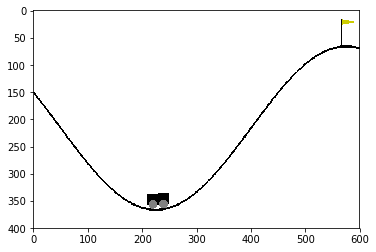

In [2]:
import gym
env = gym.make("MountainCar-v0")

plt.imshow(env.render('rgb_array'))
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
env.close()

### Gym interface

Основные методы класса __Env__:
* __reset()__ - инициализация окружения в начальном состоянии _возвращает первое наблюдение_,
* __render()__ - показать текущее состояние среды,
* __step(a)__ - выполнить действие __a__ и получить (new observation, reward, is done, info)
 * _new observation_ - новое наблюдение после выполнения действия __a__,
 * _reward_ - вознагрждение (скаляр) за выполненное действие __a__,
 * _is done_ - True, если процесс (марковский!) завершился, False иначе,
 * _info_ - дополнительная информация.

In [3]:
obs0 = env.reset()
print("initial observation code:", obs0)
print("taking action 2 (right)")
new_obs, reward, is_done, _ = env.step(2)

print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)

initial observation code: [-0.56965483  0.        ]
taking action 2 (right)
new observation code: [-0.56831051  0.00134432]
reward: -1.0
is game over?: False


### Задание 1
Наша цель, чтобы тележка достигла флага. Модифицируйте код ниже для выполнения этого задания:

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<IPython.core.display.Javascript object>


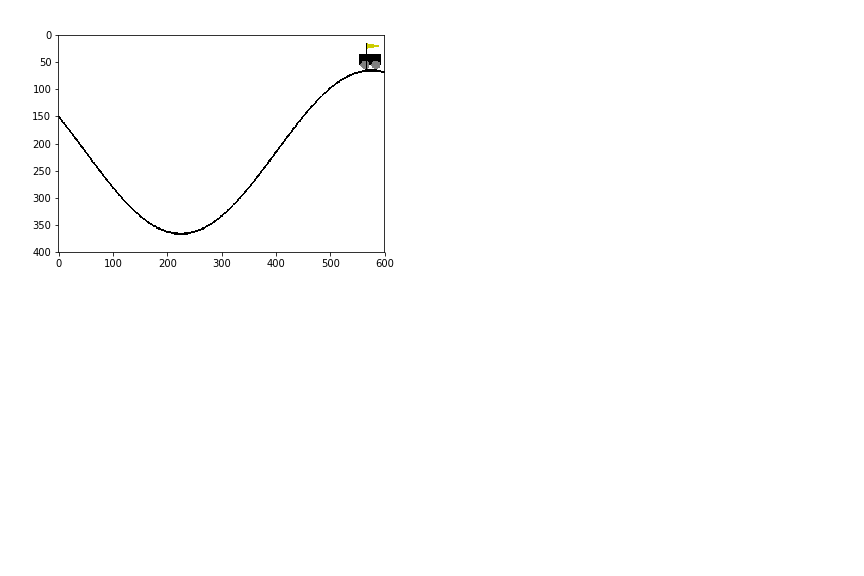

Well done!
You solved it!


<IPython.core.display.Javascript object>


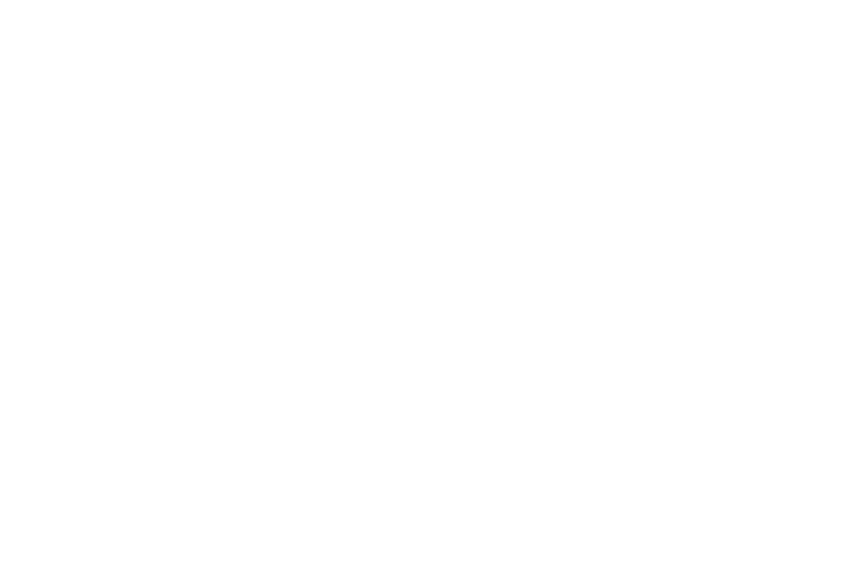

In [4]:
TIME_LIMIT = 250
env = gym.wrappers.TimeLimit(gym.envs.classic_control.MountainCarEnv(),
                             max_episode_steps=TIME_LIMIT + 1)
s = env.reset()
actions = {'left': 0, 'stop': 1, 'right': 2}

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for t in range(TIME_LIMIT):
    if s[1] > 0:
        s, r, done, _ = env.step(actions['right'])
    else:
        s, r, done, _ = env.step(actions['left'])

    #draw game image on display
    ax.clear()
    ax.imshow(env.render('rgb_array'))
    fig.canvas.draw()
    
    if done:
        print("Well done!")
        break
else:    
    print("Time limit exceeded. Try again.")
    
env.close()
assert s[0] > 0.47
print("You solved it!")


## Вероятностный подход к RL

Пусть наша стратегия - это вероятностное распределение:

$\pi(s,a) = P(a|s)$

Рассмотрим пример с задачей Taxi [Dietterich, 2000]. Для нее мы можем считать, что наша стратегия - это двумерный массив.

In [5]:
%matplotlib inline

env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


### Задание 2

Создадим "равномерную" стратегию в виде двумерного массива с равномерным рапсределением по действиям и сгенерируем игровую сессию с такой стратегией.

In [32]:
policy = np.array([[1./n_actions for _ in range(n_actions)] for _ in range(n_states)])

assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

In [33]:
def generate_session(policy,t_max=10**4):
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(n_actions, p=policy[s])
        
        new_s,r,done,info = env.step(a)
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done:
            break
    return states,actions,total_reward

In [34]:
s,a,r = generate_session(policy)

Наша задача - выделить лучшие действия и состояния, т.е. такие, при которых было лучшее вознаграждение:

In [35]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    print(reward_threshold)
    elite_states  = [session for session_i, session in enumerate(states_batch) if rewards_batch[session_i] >= reward_threshold]
    elite_states = [state for session in elite_states for state in session]
    elite_actions = [session for session_i, session in enumerate(actions_batch) if rewards_batch[session_i] >= reward_threshold]
    elite_actions = [action for session in elite_actions for action in session]
    
    return elite_states,elite_actions

In [36]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

3.0
3.6
4.8
5.0
Ok!


Теперь мы хотим написать обновляющуюся стратегию

In [37]:
def update_policy(elite_states,elite_actions):
    """
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states,n_actions])
    
    for state in range(n_states):
        occur = 0
        for pos, s in enumerate(elite_states):
            if s == state:
                new_policy[state, elite_actions[pos]] += 1
                occur += 1
        if occur > 0:
            for a in range(n_actions):
                new_policy[state, a] /= occur
        else:
            for a in range(n_actions):
                new_policy[state, a] = 1./n_actions
       
    
    return new_policy

In [38]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

Ok!


Визуализириуем наш процесс обучения и будем измерять распределение получаемых за сессию вознаграждений 

In [39]:
from IPython.display import clear_output

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend(loc=4)
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend(loc=1)
    plt.grid()

    plt.show()

mean reward = -35.880, threshold=7.000


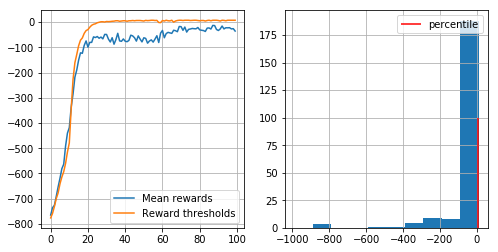

In [40]:
policy = np.ones([n_states,n_actions])/n_actions 
n_sessions = 250  #sample this many sessions
percentile = 50  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch, percentile)
    
    new_policy = update_policy(elite_states, elite_actions)
    
    policy = learning_rate*new_policy + (1-learning_rate)*policy
    
    #display results on chart
    show_progress(rewards_batch,log)

Видим, что модель обучается. Особенность: по 50 перцентилю порог стремится к оптимальному значению +20, хотя и не превышает +10, а среднее вознаграждение сильно колеблется в районе (-80;-20). Это объясняется веротяностой природой стратегии.

## Подход на основе функций оценки

Рассмотрим алгоритм итерации по оценкам состояниям $V$ (Value Iteration):

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

На основе оценки $V_i$ можно посчитать функцию оценки $Q_i$ действия $a$ в состоянии $s$:

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

$$V_{(i+1)}(s) = \max_a Q_i(s,a)$$

Зададим напрямую модель MDP с картинки в начале тетрадки.

In [16]:
transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1': {'s2': 1}
  },
  's1':{
    'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
    'a1': {'s1': 0.95, 's2': 0.05}
  },
  's2':{
    'a0': {'s0': 0.4, 's1': 0.6},
    'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
  }
}
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

In [17]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Задание 3

Реализуем итерационное вычисление функций $V$ и $Q$ и применим их для заданого вручную MDP (см. картинку в начале тетрадки) и классчической задачи FrozenLake.

In [18]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """
    
    
    Q = sum([(prob * (mdp.get_reward(state, action, s) + gamma * state_values[s])) 
             for s, prob in mdp.get_next_states(state, action).items()])
    
    return Q

In [19]:
test_Vs = {s : i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.allclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)

In [20]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state): return 0
    
    V = max([sum([prob*(mdp.get_reward(state, action, s) + gamma * state_values[s]) 
                  for s, prob in mdp.get_next_states(state, action).items()])
             for action in mdp.get_possible_actions(state)])
    return V

In [21]:
test_Vs_copy = dict(test_Vs)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)

In [22]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
min_difference = 0.001 # stop VI if new values are this close to old values (or closer)

# initialize V(s)
state_values = {s : 0 for s in mdp.get_all_states()}


for i in range(num_iter):
    
    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    #new_state_values = <YOUR CODE HERE>
    new_state_values = {s : get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}
    
    assert isinstance(new_state_values, dict)
    
    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   "%(i, diff), end="")
    print('   '.join("V(%s) = %.3f"%(s, v) for s,v in state_values.items()), end='\n\n')
    state_values = new_state_values
    
    if diff < min_difference:
        print("Terminated"); break

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000

iter    1   |   diff: 1.89000   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000

iter    2   |   diff: 1.70100   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 1.890

iter    3   |   diff: 1.13542   |   V(s0) = 1.701   V(s1) = 4.184   V(s2) = 2.060

iter    4   |   diff: 0.73024   |   V(s0) = 1.854   V(s1) = 5.319   V(s2) = 2.871

iter    5   |   diff: 0.61135   |   V(s0) = 2.584   V(s1) = 5.664   V(s2) = 3.540

iter    6   |   diff: 0.54664   |   V(s0) = 3.186   V(s1) = 6.275   V(s2) = 3.989

iter    7   |   diff: 0.49198   |   V(s0) = 3.590   V(s1) = 6.790   V(s2) = 4.535

iter    8   |   diff: 0.42210   |   V(s0) = 4.082   V(s1) = 7.189   V(s2) = 4.959

iter    9   |   diff: 0.36513   |   V(s0) = 4.463   V(s1) = 7.611   V(s2) = 5.352

iter   10   |   diff: 0.32862   |   V(s0) = 4.816   V(s1) = 7.960   V(s2) = 5.717

iter   11   |   diff: 0.29262   |   V(s0) = 5.145   V(s1) = 8.280   V(s2) = 6.032

iter

In [23]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 8.032)  < 0.01

Final state values: {'s0': 8.023123818663871, 's1': 11.163174814980803, 's2': 8.915559364985523}


In [24]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state): return None
    
    actions = mdp.get_possible_actions(state)
    i = np.argmax([get_action_value(mdp, state_values, state, action, gamma) for action in actions])
    
    
    return actions[i]

In [25]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'

In [26]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [27]:
def value_iteration(mdp, state_values=None, gamma = 0.9, num_iter = 1000, min_difference = 1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s : 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {s : get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}
        
        assert isinstance(new_state_values, dict)

        # Compute difference
        diff =  max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
        
        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f "%(i, diff, new_state_values[mdp._initial_state]))
        
        state_values = new_state_values
        if diff < min_difference:
            break
            
    return state_values

In [28]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 


In [29]:
def draw_policy(mdp, state_values):
    plt.figure(figsize=(3,3))
    h,w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w,h), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down':(0, -1), 'right':(1,0), 'up':(-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y,x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None: continue
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 29
iter    0   |   diff: 0.00000   |   V(start): 0.198 


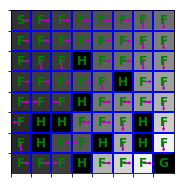

In [30]:
from time import sleep

mdp = FrozenLakeEnv(map_name='8x8',slip_chance=0.1)
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

In [31]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

iter    0   |   diff: 0.75000   |   V(start): 0.000 
iter    1   |   diff: 0.50625   |   V(start): 0.000 
iter    2   |   diff: 0.39867   |   V(start): 0.000 
iter    3   |   diff: 0.26910   |   V(start): 0.000 
iter    4   |   diff: 0.18164   |   V(start): 0.000 
iter    5   |   diff: 0.14013   |   V(start): 0.140 
iter    6   |   diff: 0.07028   |   V(start): 0.199 
iter    7   |   diff: 0.06030   |   V(start): 0.260 
iter    8   |   diff: 0.02594   |   V(start): 0.285 
iter    9   |   diff: 0.01918   |   V(start): 0.305 
iter   10   |   diff: 0.00858   |   V(start): 0.313 
iter   11   |   diff: 0.00560   |   V(start): 0.319 
iter   12   |   diff: 0.00260   |   V(start): 0.321 
iter   13   |   diff: 0.00159   |   V(start): 0.323 
iter   14   |   diff: 0.00076   |   V(start): 0.324 
iter   15   |   diff: 0.00045   |   V(start): 0.324 
iter   16   |   diff: 0.00022   |   V(start): 0.324 
iter   17   |   diff: 0.00012   |   V(start): 0.325 
iter   18   |   diff: 0.00006   |   V(start): 